In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import sedov
from fvhoe.solver import EulerSolver
from fvhoe.visualization import sample_circular_average
import matplotlib.pyplot as plt
import numpy as np
from sedov import sedov_rduP

In [2]:
# sedov blast params
t = 0.7
gamma = 1.4

In [3]:
# numerical solution
N = 32
p = 3

solver = EulerSolver(
    w0=partial(sedov, dims="xy"),
    conservative_ic=True,
    fv_ic=True,
    x=(0, 1),
    y=(0, 1),
    gamma=gamma,
    bc=BoundaryCondition(x=("reflective", "outflow"), y=("reflective", "outflow")),
    CFL=0.8,
    nx=N,
    ny=N,
    px=p,
    py=p,
    riemann_solver="hllc",
    a_posteriori_slope_limiting=True,
    slope_limiter="minmod",
    NAD=1e-3,
    all_floors=True,
    snapshots_as_fv_averages=False,
    cupy=False,
)
solver.rkorder(t)

/home/jp7427/.conda/envs/fvhoe-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jp7427/.conda/envs/fvhoe-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 0.7/0.7 [00:15]                  


In [4]:
# analytical solution
r, d, u, P = sedov_rduP(t=t, dim=2, gamma=gamma)

chi0=1.0040002436392572


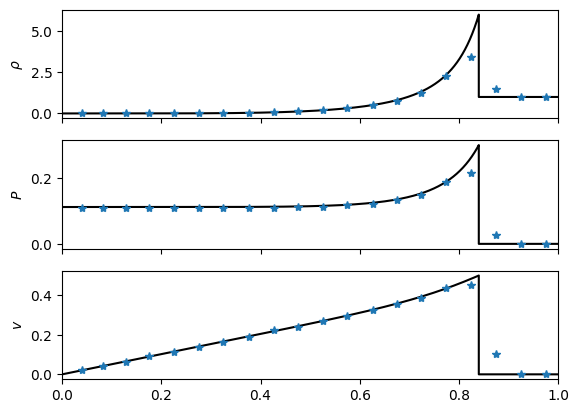

In [5]:
fig, ax = plt.subplots(3, 1, sharex=True)

# plot analytical solution
ax[0].set_ylabel(r"$\rho$")
ax[0].plot(r, d, "k")
ax[1].set_ylabel(r"$P$")
ax[1].plot(r, P, "k")
ax[2].set_ylabel(r"$v$")
ax[2].plot(r, u, "k")
ax[2].set_xlim(0, 1)

# sample numerical solution
radii = np.linspace(0, 1, 21)
avg_rho, avg_r = sample_circular_average(
    solver, param="rho", center=(0, 0, 0.5), radii=radii
)
avg_P, _ = sample_circular_average(solver, param="P", center=(0, 0, 0.5), radii=radii)
avg_v, _ = sample_circular_average(solver, param="v", center=(0, 0, 0.5), radii=radii)
ax[0].plot(avg_r, avg_rho, linestyle="none", marker="*")
ax[1].plot(avg_r, avg_P, linestyle="none", marker="*")
ax[2].plot(avg_r, avg_v, linestyle="none", marker="*")

t=0.7, x=[0.015625, 0.984375], y=[0.015625, 0.984375], z=0.5
horizontal_axis='x', vertical_axis='y'


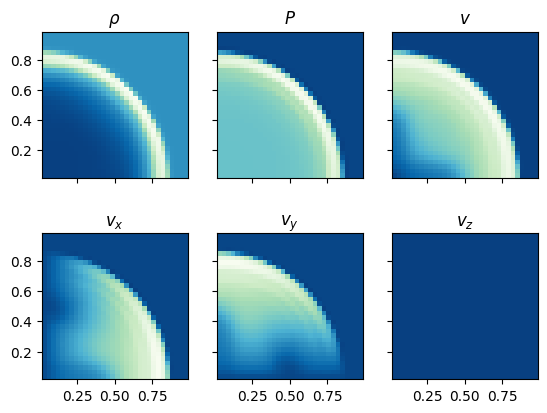

In [6]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)

indexing = dict(z=0.5, t=t)

# density
ax[0, 0].set_title(r"$\rho$")
solver.plot_2d_slice(ax[0, 0], param="rho", **indexing)

# pressure
ax[0, 1].set_title(r"$P$")
solver.plot_2d_slice(ax[0, 1], param="P", verbose=False, **indexing)

# velocity magnitude
ax[0, 2].set_title(r"$v$")
solver.plot_2d_slice(ax[0, 2], param="v", verbose=False, **indexing)

# velocity components
ax[1, 0].set_title(r"$v_x$")
solver.plot_2d_slice(ax[1, 0], param="vx", verbose=False, **indexing)

ax[1, 1].set_title(r"$v_y$")
solver.plot_2d_slice(ax[1, 1], param="vy", verbose=False, **indexing)

ax[1, 2].set_title(r"$v_z$")
solver.plot_2d_slice(ax[1, 2], param="vz", verbose=False, **indexing)

symmetry l1 err : 7.553442280611457e-16


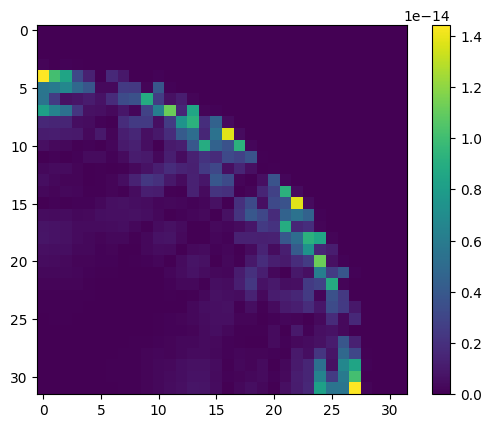

In [8]:
# pressure asymmetry
P = solver.snapshots[-1]["w"].P[:, :, 0]
plt.imshow(np.rot90(np.abs(P - P.T), 1))
plt.colorbar()
print(f"symmetry l1 err : {np.mean(np.abs(P - P.T))}")